# import libraries

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
from albumentations import CenterCrop, Compose, Normalize
from albumentations.pytorch import ToTensorV2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (average_precision_score, balanced_accuracy_score,
                             matthews_corrcoef, roc_auc_score)
from sklearn.model_selection import GroupKFold
from torch.utils.data import DataLoader
from tqdm import tqdm

from clmodel.dataset import CLModelDataset
from clmodel.data_split import RepeatedStratifiedGroupKFold
from clmodel.model import FrozenResNet50ModelMO, ResNet50ModelMO
from clmodel.utils import fix_seed

## load dataset

In [2]:
test_df = pd.read_csv("../../data/TGGATEs/processed/test_for_finding_types.csv")

In [3]:
test_df["path"] = test_df["path"].str.replace("HDD", "extHDD1")

In [4]:
ft_list = list(test_df.columns[3:11])
ft_list


['Proliferation, bile duct',
 'Ground glass appearance',
 'Increased mitosis',
 'Inclusion body, intracytoplasmic',
 'Deposit, pigment',
 'Single cell necrosis',
 'Vacuolization, cytoplasmic',
 'Swelling']

## fix seed

In [5]:
seed = 123
fix_seed(seed)


## define image preprocessing

In [6]:
image_size = 512

vl_transform = Compose([CenterCrop(image_size, image_size), Normalize(), ToTensorV2()])


In [10]:
test_dataset = CLModelDataset(
    test_df["path"].values, test_df[ft_list].values >= 0.5, transform=vl_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    drop_last=False,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

model_control = timm.create_model("resnetaa50", pretrained=True, num_classes=0)
model_control.eval()
model_control.to("cuda")

models_list = []
for ft in tqdm(ft_list + ["whole"]):
    if ft != "whole":
        save_dir = f"../../outputs/230305TGGATEs_ft_loo_{ft}_seed123_epoch5_resnet"
        models = [FrozenResNet50ModelMO(i, len(ft_list) - 1) for i in range(5)] + [ResNet50ModelMO(num_classes=len(ft_list) - 1)]
    else:
        save_dir = "../../outputs/230305TGGATEs_model_seed123_epoch5_resnet"
        models = [FrozenResNet50ModelMO(i, len(ft_list)) for i in range(5)] + [ResNet50ModelMO(num_classes=len(ft_list))]
    for i, model in enumerate(models):
        if ft == "whole":
            if i<=4:
                model.load_state_dict(
                    torch.load(f"{save_dir}/{i}/effnetb4_freeze{i}_fold0_best_loss.pth")
                )
                model.classifier = nn.Identity()
            else:
                model.model.load_state_dict(
                    torch.load(f"{save_dir}/{i}/effnetb4_freeze{i}_fold0_best_loss.pth")
                )
                model.classifier = nn.Identity()
        else:
            if i<=4:
                model.load_state_dict(
                    torch.load(f"{save_dir}/{i}/resnet50aa_freeze{i}_fold0_best_loss.pth")
                )
                model.classifier = nn.Identity()
            else:
                model.model.load_state_dict(
                    torch.load(f"{save_dir}/{i}/resnet50aa_freeze{i}_fold0_best_loss.pth")
                )
                model.classifier = nn.Identity()

        model.to("cuda")
        model.eval()
    models_list.append(models)


100%|██████████| 9/9 [00:20<00:00,  2.32s/it]


In [11]:
features_control = []
features = [[[[] for k in range(5)] for i in range(6)] for ft in ft_list + ["whole"]]
with torch.no_grad():
    for im, _ in tqdm(test_loader):
        im = im.to("cuda")
        outputs = model_control(im)
        features_control.append(outputs.to("cpu").numpy())
        for i in range(len(ft_list) + 1):
            for j in range(6):
                outputs = models_list[i][j](im)
                for k, f in enumerate(outputs):
                    features[i][j][k].append(f.to("cpu").numpy())


100%|██████████| 1178/1178 [2:12:52<00:00,  6.77s/it] 


## save features

In [12]:
import pickle

with open("../../outputs/230308ft_validation_features_seed123_epoch5_resnet.pickle", "wb") as f:
    pickle.dump({"features":features, "features_control":features_control}, f)

In [39]:
# features_control = np.concatenate(features_control)
# with open("../../outputs/230308ft_validation_features_control.pickle", "wb") as f:
#     pickle.dump(features_control, f)

In [10]:
with open("../../outputs/230308ft_validation_features.pickle", "rb") as f:
    features = pickle.load(f)

EOFError: Ran out of input

In [13]:
def eval(gt, pr):
    return [
        roc_auc_score(gt >= 0.5, pr),
        matthews_corrcoef(gt >= 0.5, pr >= 0.5),
        balanced_accuracy_score(gt >= 0.5, pr >= 0.5),
        (average_precision_score(gt >= 0.5, pr) + average_precision_score(gt < 0.5, -pr))/2,
    ]


def logreg(X, y, ft_i, train_idx, valid_idx):
    r = []
    X_train = X[train_idx]
    y_train = y[train_idx] >= 0.5
    X_valid = X[valid_idx]
    y_valid = y[valid_idx] >= 0.5
    lr = LogisticRegression(max_iter=100, n_jobs=8)
    lr.fit(X_train, y_train[:, ft_i])
    y_preds = lr.predict_proba(X_valid)[:, 1]
    rr = eval(y_valid[:, ft_i], y_preds)
    r.append(rr)
    return np.array(r)


In [19]:
model

ResNet50ModelMO(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, 

In [14]:
rsgkf = RepeatedStratifiedGroupKFold(n_splits=5, random_state=42)
spl = rsgkf.split(features_control, (test_df[ft_list].values>=0.5).astype(np.int64), test_df["EG"].values)
train_idx, valid_idx = next(spl)

In [15]:
(test_df[ft_list].values>=0.5)[train_idx].sum(axis=0)

array([3523, 2750, 3240,  296,  403, 2995, 3879, 1168])

In [16]:
(test_df[ft_list].values>=0.5)[valid_idx].sum(axis=0)

array([1199, 1091,  208,  200,  200,  701,  100, 1987])

In [18]:
res_dict = {}
for ft_i in range(8):
    print(ft_list[ft_i])
    results = []
    results.append(logreg(np.concatenate(features_control), test_df[ft_list].values, ft_i, train_idx, valid_idx))

    for frozen in range(6):
        for depth in tqdm(range(5)):
            results.append(
                logreg(
                    np.concatenate(features[ft_i][frozen][depth]),
                    test_df[ft_list].values,
                    ft_i,
                    train_idx, valid_idx,
                )
            )
    results.append(
        logreg(
            test_df[[ft for i, ft in enumerate(ft_list) if i!=ft_i]].to_numpy(),
            test_df[ft_list].values,
            ft_i,
            train_idx, valid_idx,
        )
    )

    res_dict[ft_list[ft_i]] = results


Proliferation, bile duct


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Ground glass appearance


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Increased mitosis


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Inclusion body, intracytoplasmic


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Deposit, pigment


  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 20%|██        | 1/5 [00:01<00:05,  1.50s/it]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:


Single cell necrosis


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Vacuolization, cytoplasmic


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Swelling


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [20]:
data = []
model_name = ["Control"] + [f"Layer {4-i}" for i in range(4)] + ["Full"]
layer_name = ["Stem"] +  [f"Layer {i}" for i in range(1, 5)] 

for ft in ft_list:
    results = res_dict[ft]
    res = np.concatenate(results[1:-1]).reshape(6, 5, 4)
    for i in range(6):
        for j in range(5):
            data.append(
                (
                    model_name[i],
                    layer_name[j],
                    ft,
                    res[i, j, 0],
                    res[i, j, 1],
                    res[i, j, 2],
                    res[i, j, 3],
                )
            )
    data.append(
            (
                "Pathological Findings",
                "-",
                ft,
                results[-1][0, 0],
                results[-1][0, 1],
                results[-1][0, 2],
                results[-1][0, 3],
            )
        )

score_df = pd.DataFrame(
    data,
    columns=[
        "model",
        "layer",
        "pathological findings",
        "AUROC",
        "MCC",
        "Balanced Accuracy",
        "AP",
    ],
)
score_df.to_csv(
    "../../outputs/results/230308finding_type_validation_loo_seed123_epoch5_resnet.csv", index=False
)


In [21]:
score_df

,model,layer,pathological findings,AUROC,MCC,Balanced Accuracy,AP
0,Control,Stem,"Proliferation, bile duct",0.966797,0.744409,0.921610,0.897975
1,Control,Layer 1,"Proliferation, bile duct",0.965287,0.768471,0.941046,0.901265
2,Control,Layer 2,"Proliferation, bile duct",0.978791,0.797603,0.954784,0.933999
3,Control,Layer 3,"Proliferation, bile duct",0.967271,0.787891,0.941251,0.867381
4,Control,Layer 4,"Proliferation, bile duct",0.947049,0.689667,0.858976,0.800262
...,...,...,...,...,...,...,...
243,Full,Layer 1,Swelling,0.898519,0.608890,0.739122,0.884951
244,Full,Layer 2,Swelling,0.793440,0.714606,0.803876,0.823349
245,Full,Layer 3,Swelling,0.889682,0.727555,0.818289,0.892689
246,Full,Layer 4,Swelling,0.909453,0.733244,0.825360,0.914262


In [22]:
os.system("mkdir ../../outputs/230309TGGATE_findingtype_freeze_loo_figures_seed123_epoch5_resnet")

0

Proliferation, bile duct


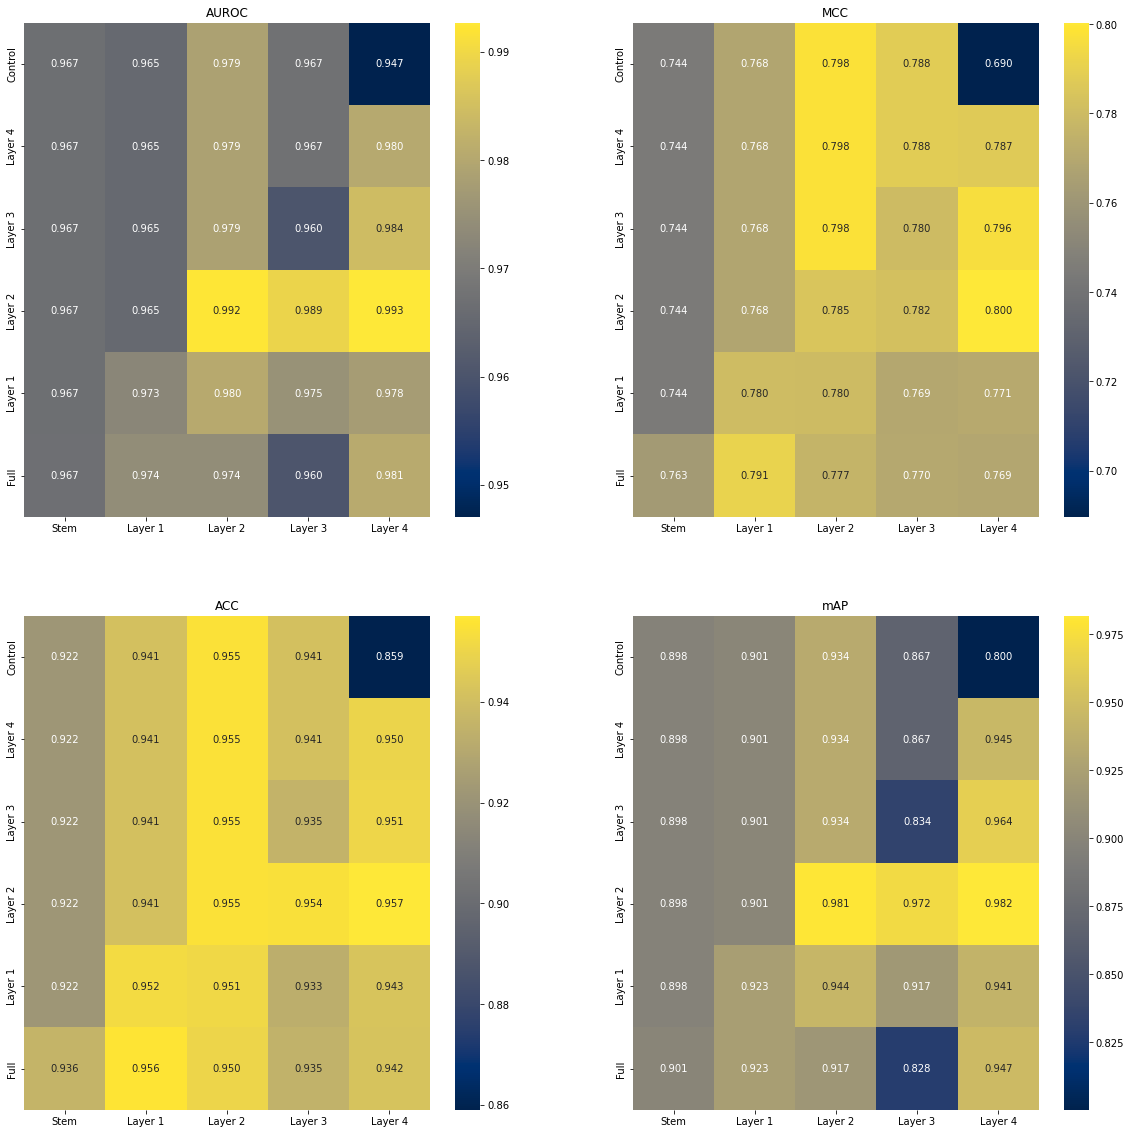

Ground glass appearance


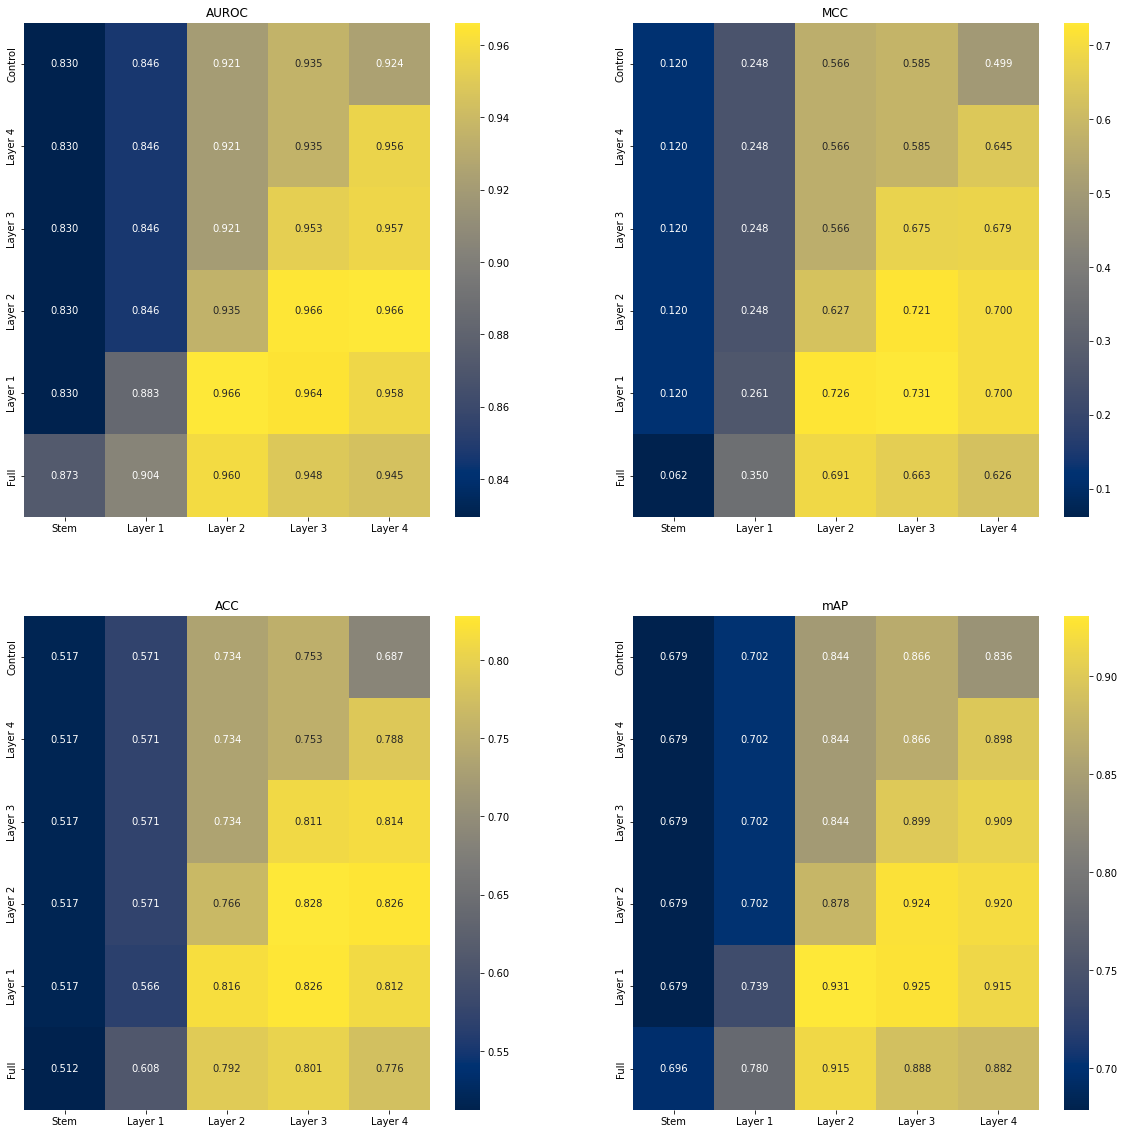

Increased mitosis


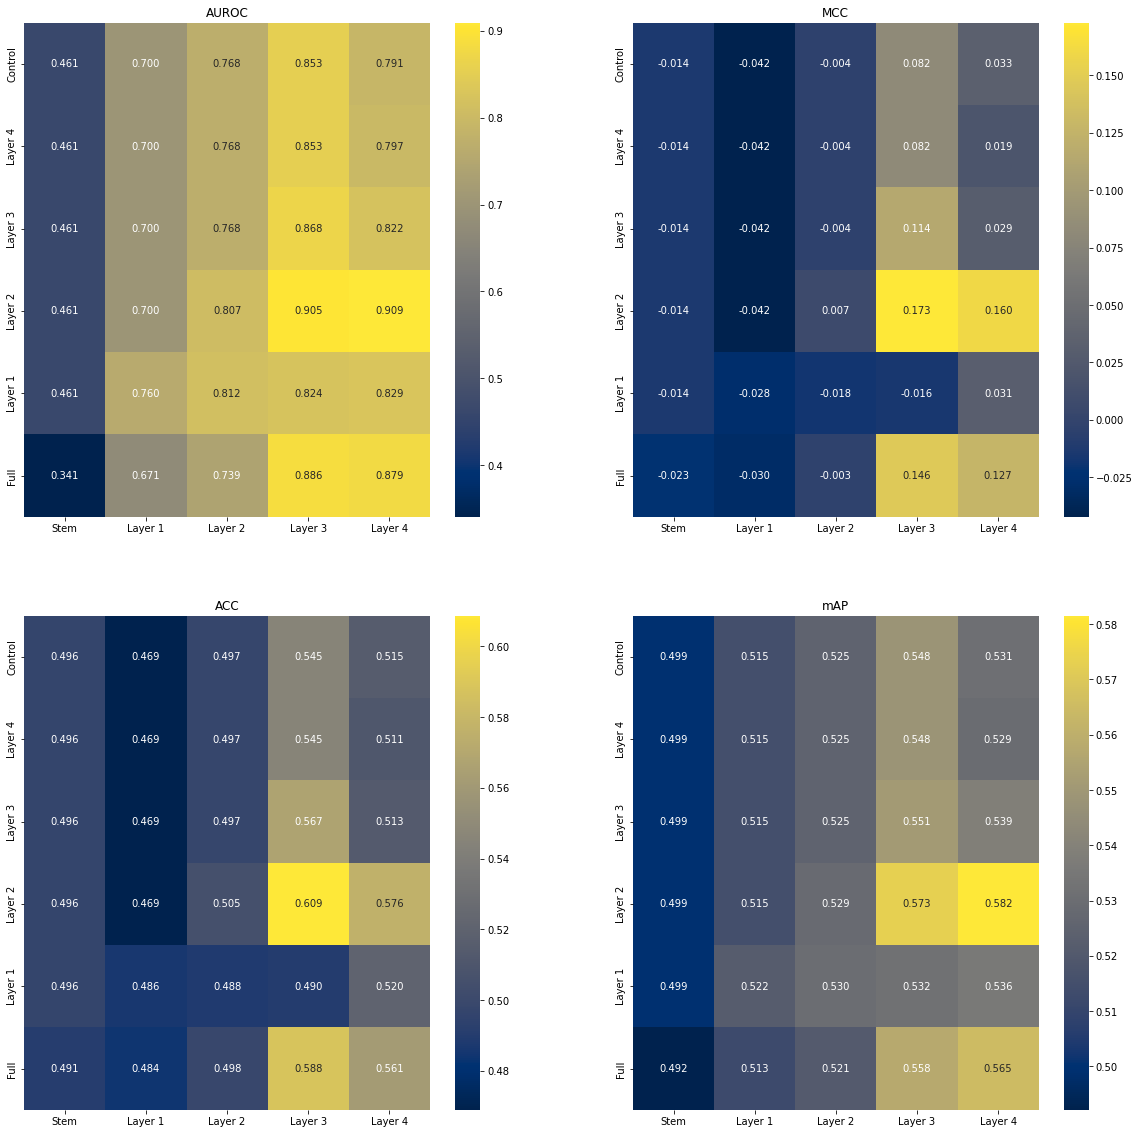

Inclusion body, intracytoplasmic


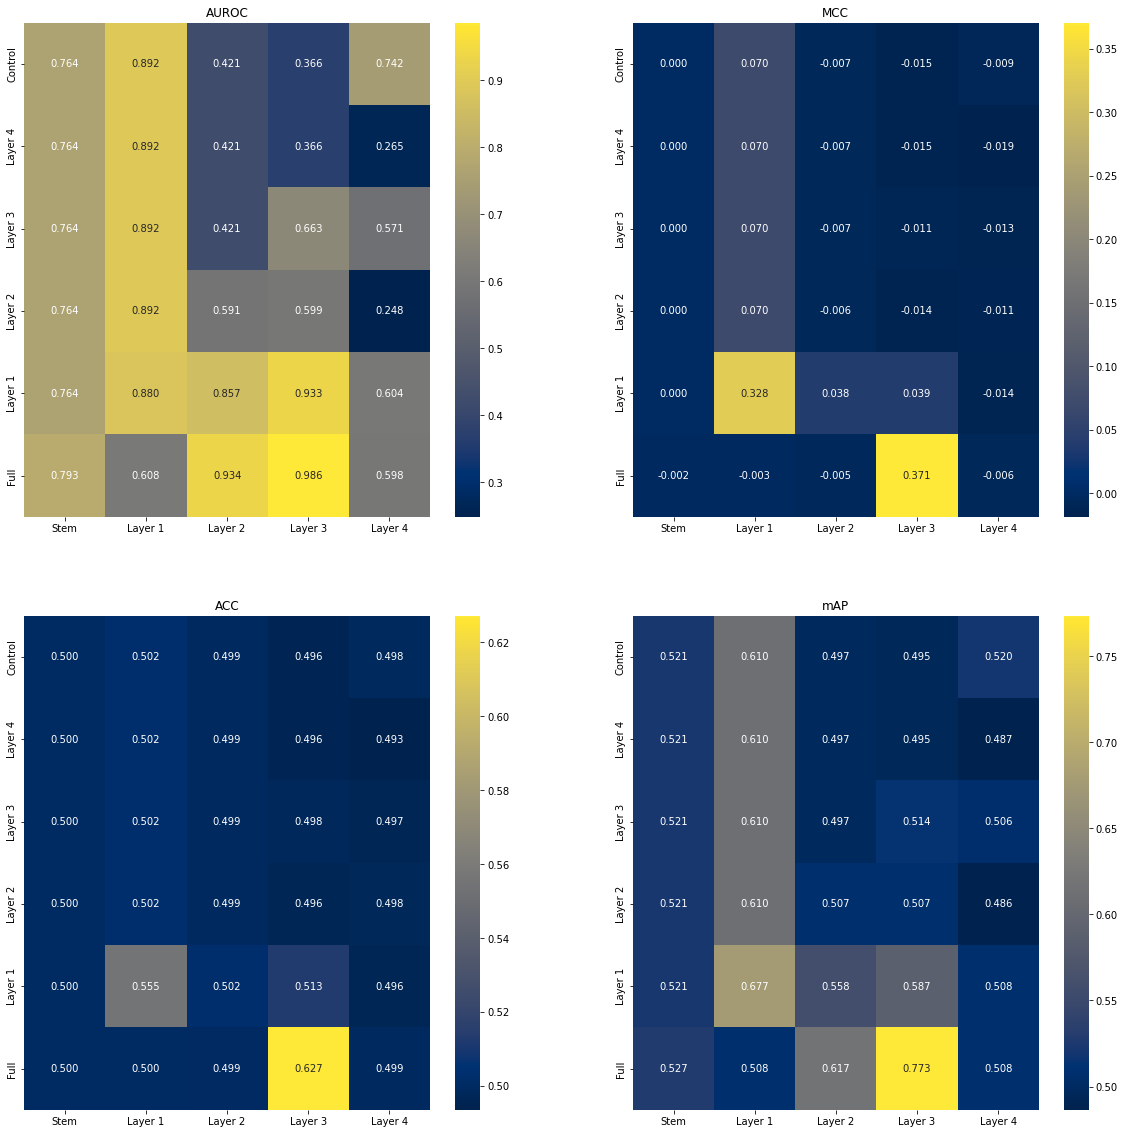

Deposit, pigment


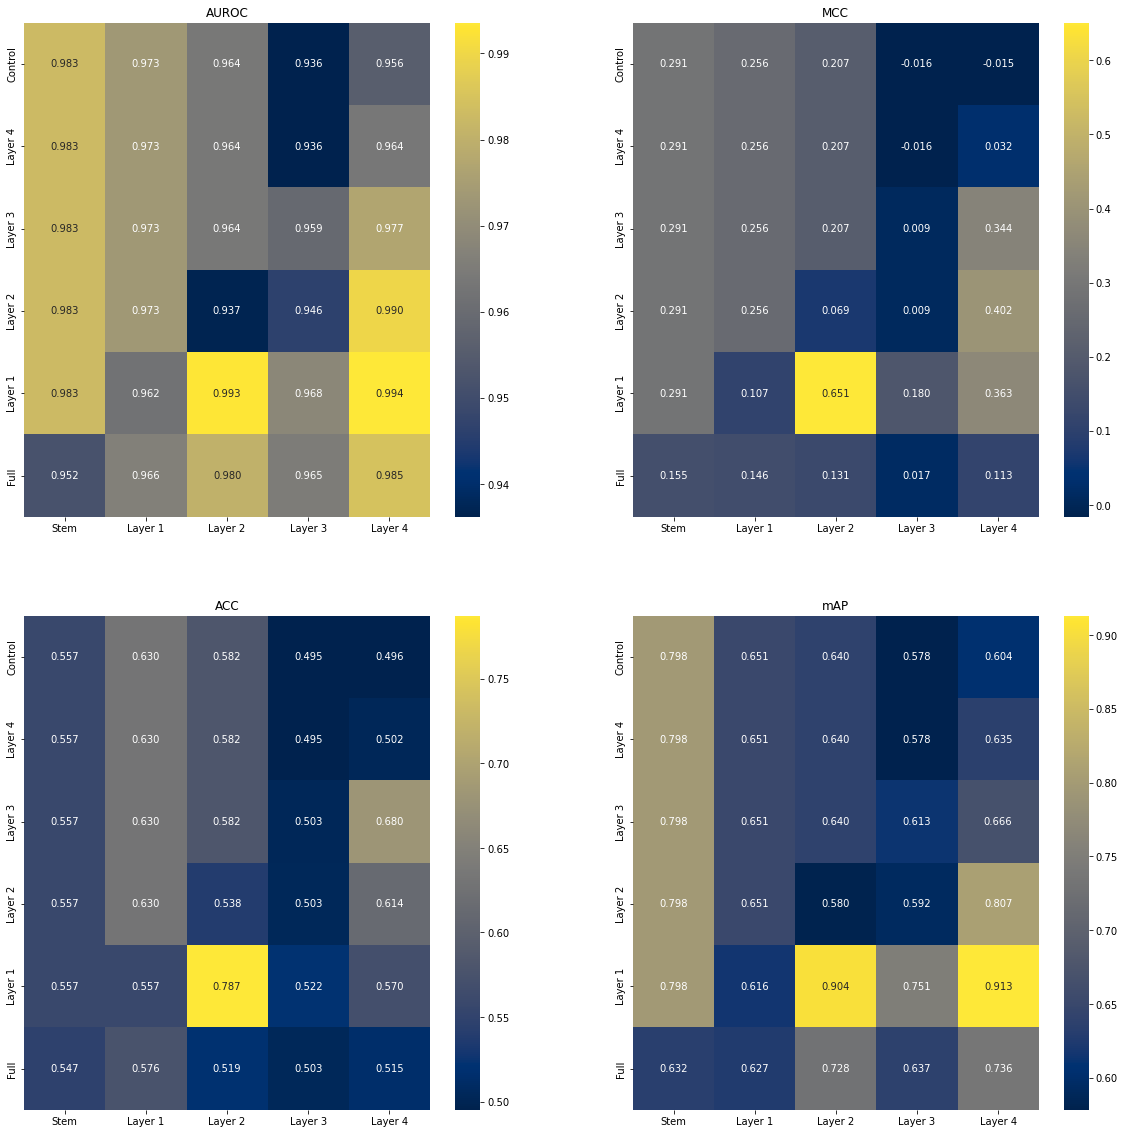

Single cell necrosis


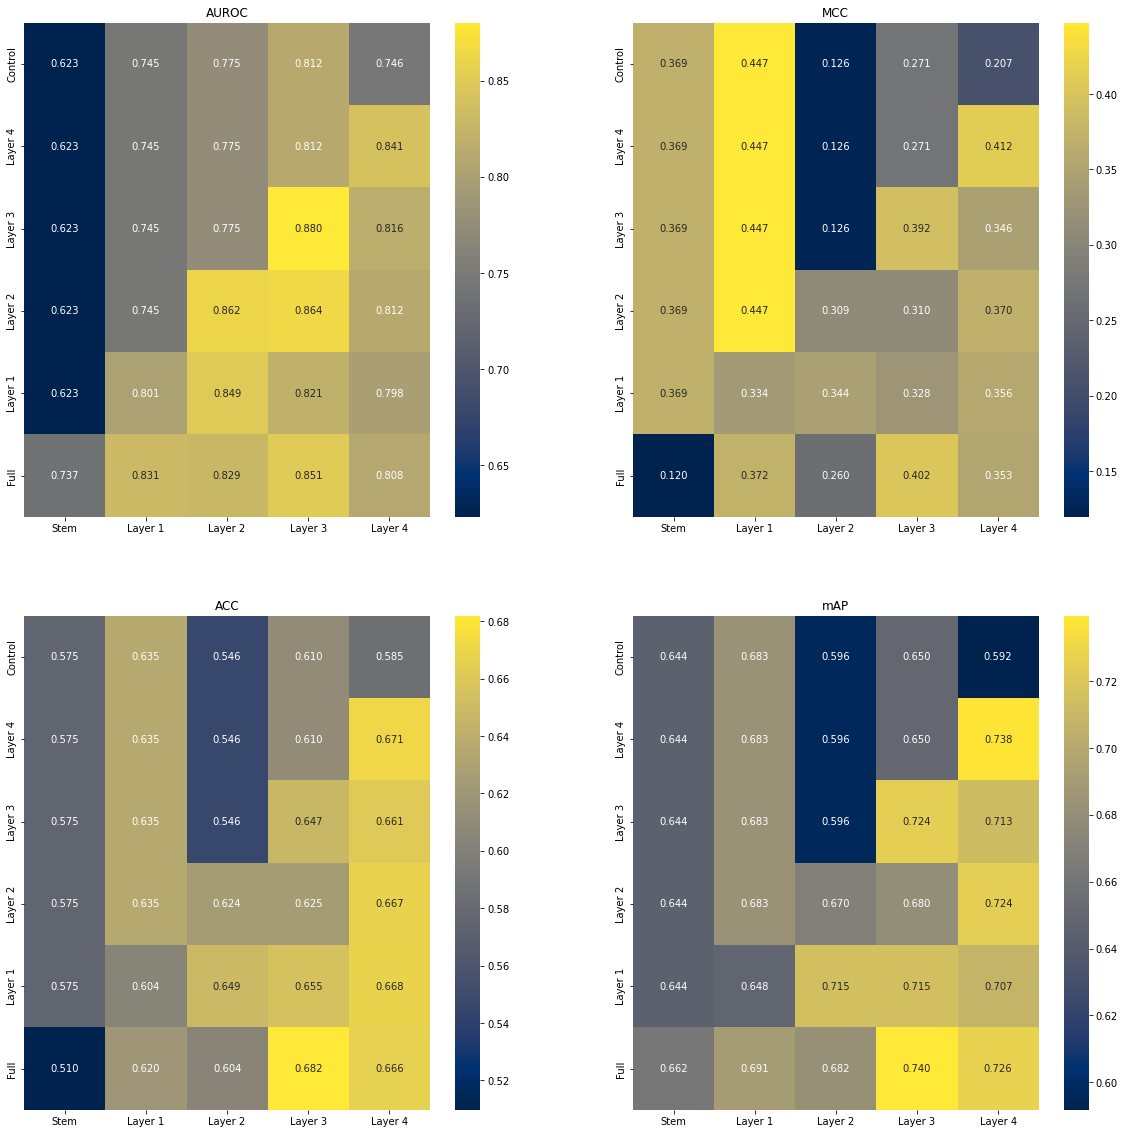

Vacuolization, cytoplasmic


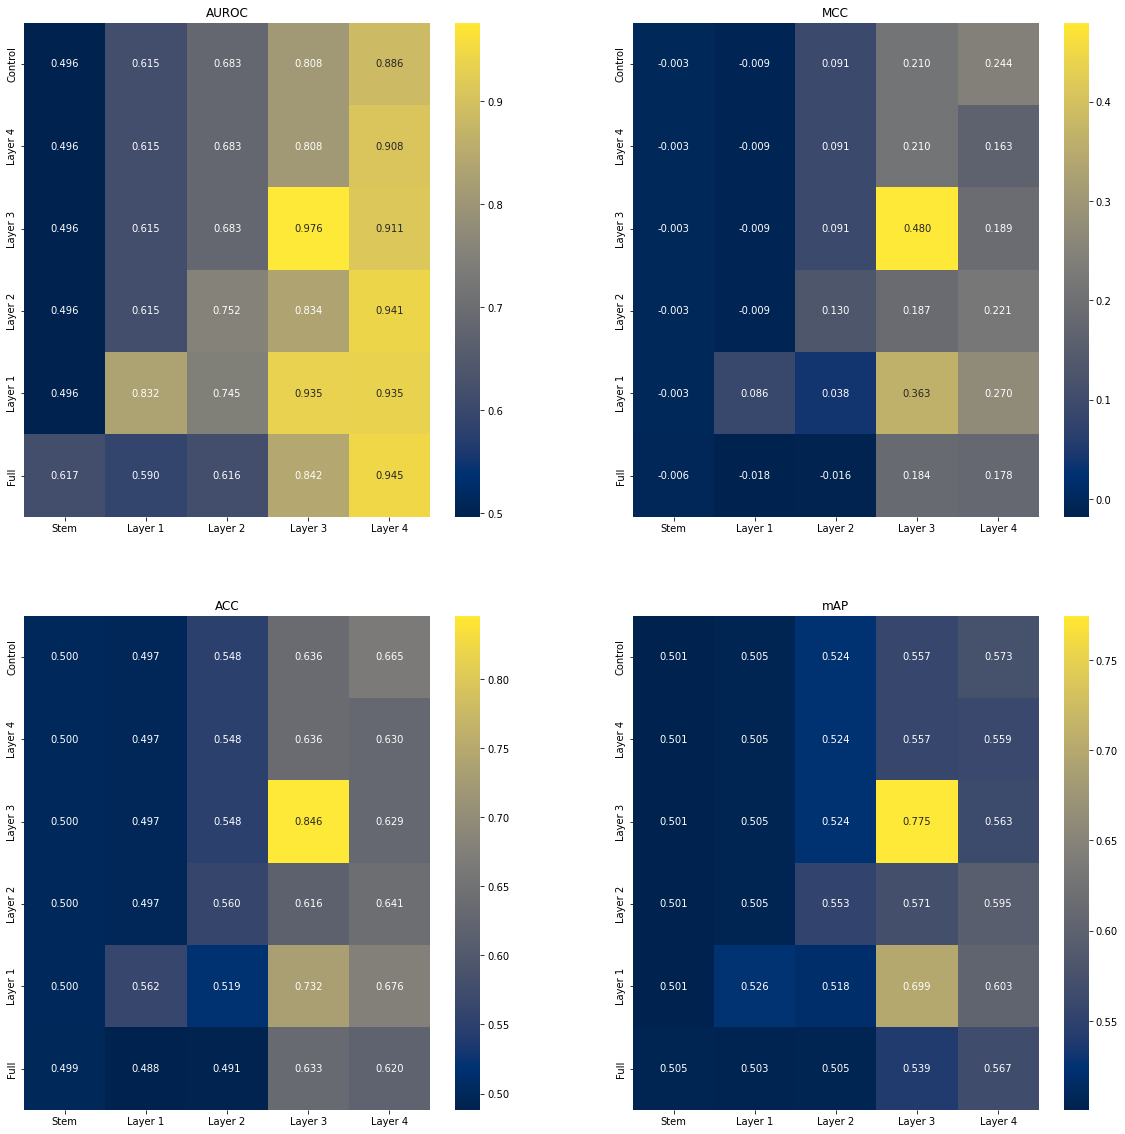

Swelling


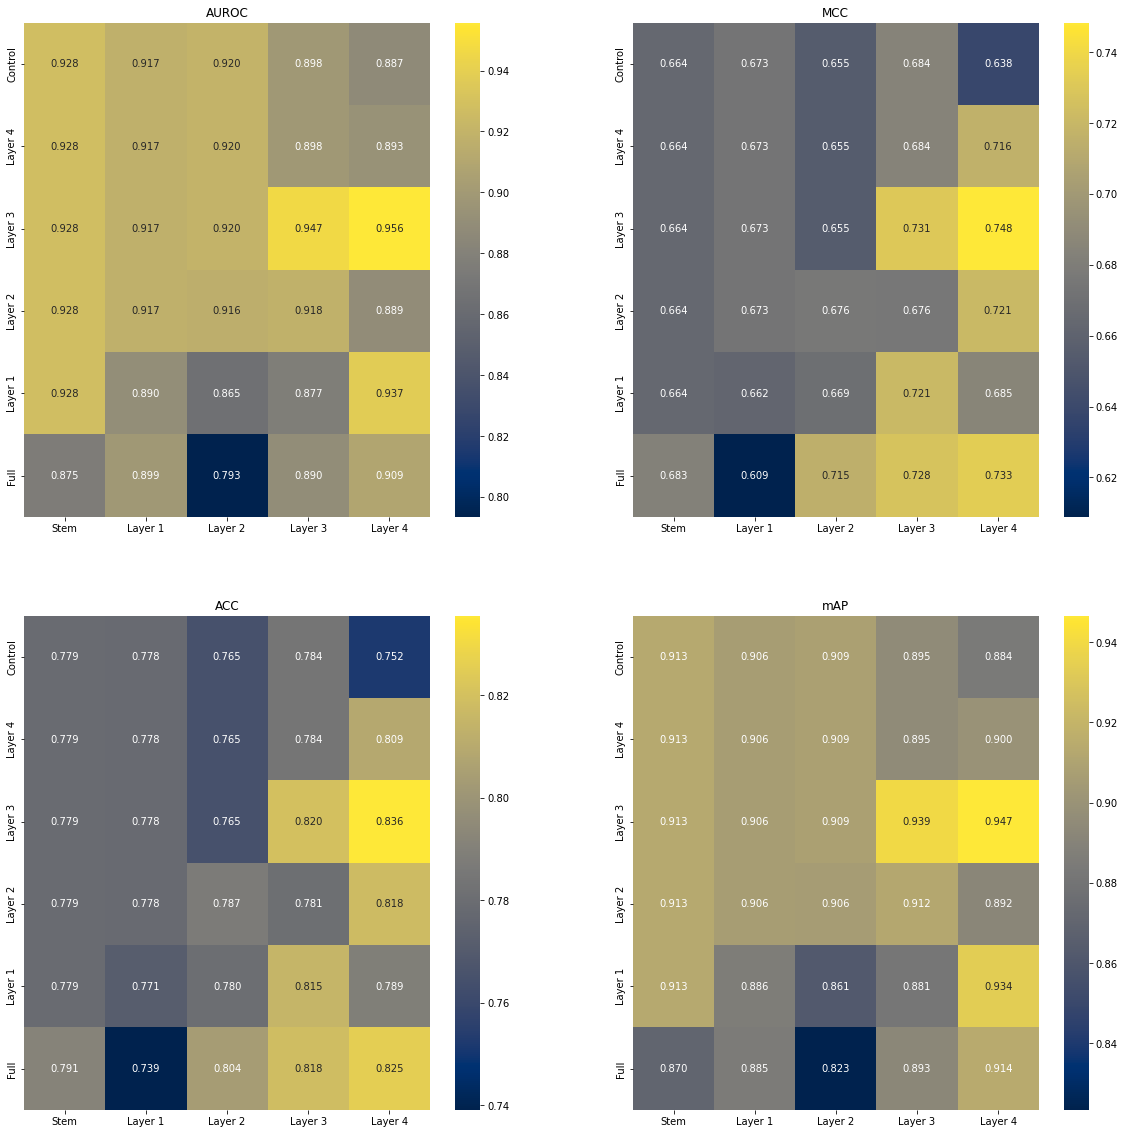

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["AUROC", "MCC", "ACC", "mAP"]
for ft in ft_list:
    results = res_dict[ft]
    res = np.concatenate(results[1:-1]).reshape(6, 5, 4)

    print(ft)
    fig = plt.figure(figsize=(20, 20))
    for i in range(4):
        df = pd.DataFrame(res[:, :, i], index=model_name, columns=layer_name)
        ax = fig.add_subplot(2, 2, i + 1)
        sns.heatmap(df, cmap="cividis", annot=True, fmt=".3f", ax=ax)
        ax.set_title(metrics[i])
    plt.savefig(f"../../outputs/230309TGGATE_findingtype_freeze_loo_figures_seed123_epoch5_resnet/{ft}.png", bbox_inches="tight")
    plt.show()


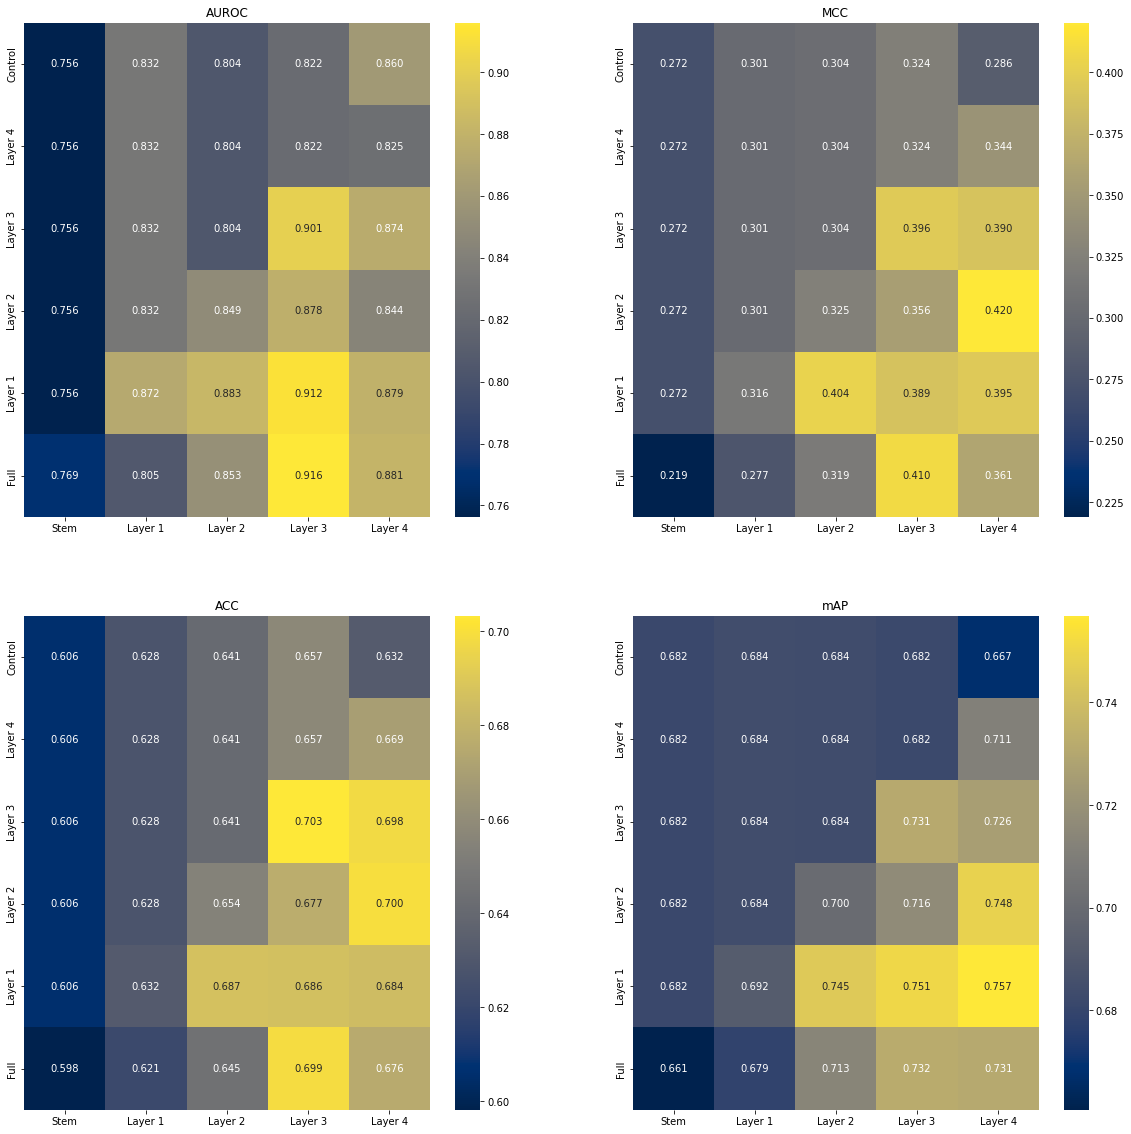

In [24]:
metrics = ["AUROC", "MCC", "ACC", "mAP"]
res_mean = 0
for ft in ft_list:
    results = res_dict[ft]
    res = np.concatenate(results[1:-1]).reshape(6, 5, 4)
    res_mean += res

fig = plt.figure(figsize=(20, 20))
for i in range(4):
    df = pd.DataFrame(res_mean[:, :, i]/len(ft_list), index=model_name, columns=layer_name)
    ax = fig.add_subplot(2, 2, i + 1)
    sns.heatmap(df, cmap="cividis", annot=True, fmt=".3f", ax=ax)
    ax.set_title(metrics[i])
plt.savefig(f"../../outputs/230309TGGATE_findingtype_freeze_loo_figures_seed123_epoch5_resnet/mean.png", bbox_inches="tight", dpi=300)
plt.show()


In [25]:
len(features)

9

In [26]:
for ft_i in range(8):
    results = []
    results.append(logreg(np.concatenate(features_control), test_df[ft_list].values, ft_i, train_idx, valid_idx))
    for frozen in range(6):
        for depth in tqdm(range(5)):
            results.append(
                logreg(
                    np.concatenate(features[8][frozen][depth]),
                    test_df[ft_list].values,
                    ft_i,
                    train_idx, valid_idx
                )
            )
    res_dict[f"whole_{ft_list[ft_i]}"] = results


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

In [30]:
res.shape

(5, 6, 4)

In [31]:
data = []
model_name = ["Control"] + [f"Layer {4-i}" for i in range(4)] + ["Full"]
layer_name = ["Stem"] +  [f"Layer {i}" for i in range(1, 5)] 

for ft in ft_list:
    results = res_dict[f"whole_{ft}"]
    res = np.concatenate(results[1:]).reshape(6, 5, 4)
    for i in range(6):
        for j in range(5):
            data.append(
                (
                    model_name[i],
                    layer_name[j],
                    ft,
                    res[i, j, 0],
                    res[i, j, 1],
                    res[i, j, 2],
                    res[i, j, 3],
                )
            )

score_df = pd.DataFrame(
    data,
    columns=[
        "model",
        "layer",
        "pathological findings",
        "AUROC",
        "MCC",
        "Balanced Accuracy",
        "AP",
    ],
)
score_df.to_csv(
    "../../outputs/results/230308finding_type_validation_seed123_epoch5_resnet.csv", index=False
)


In [32]:
score_df

,model,layer,pathological findings,AUROC,MCC,Balanced Accuracy,AP
0,Control,Stem,"Proliferation, bile duct",0.966797,0.744409,0.921610,0.897975
1,Control,Layer 1,"Proliferation, bile duct",0.965287,0.768471,0.941046,0.901265
2,Control,Layer 2,"Proliferation, bile duct",0.978791,0.797603,0.954784,0.933999
3,Control,Layer 3,"Proliferation, bile duct",0.967271,0.787891,0.941251,0.867381
4,Control,Layer 4,"Proliferation, bile duct",0.947049,0.689667,0.858976,0.800262
...,...,...,...,...,...,...,...
235,Full,Stem,Swelling,0.888949,0.693445,0.800658,0.879956
236,Full,Layer 1,Swelling,0.907494,0.637386,0.759386,0.890519
237,Full,Layer 2,Swelling,0.861016,0.673152,0.786248,0.862697
238,Full,Layer 3,Swelling,0.934655,0.730825,0.817422,0.929537


In [33]:
os.system("mkdir ../../outputs/230308TGGATE_findingtype_figures_seed123_epoch5_resnet")

0

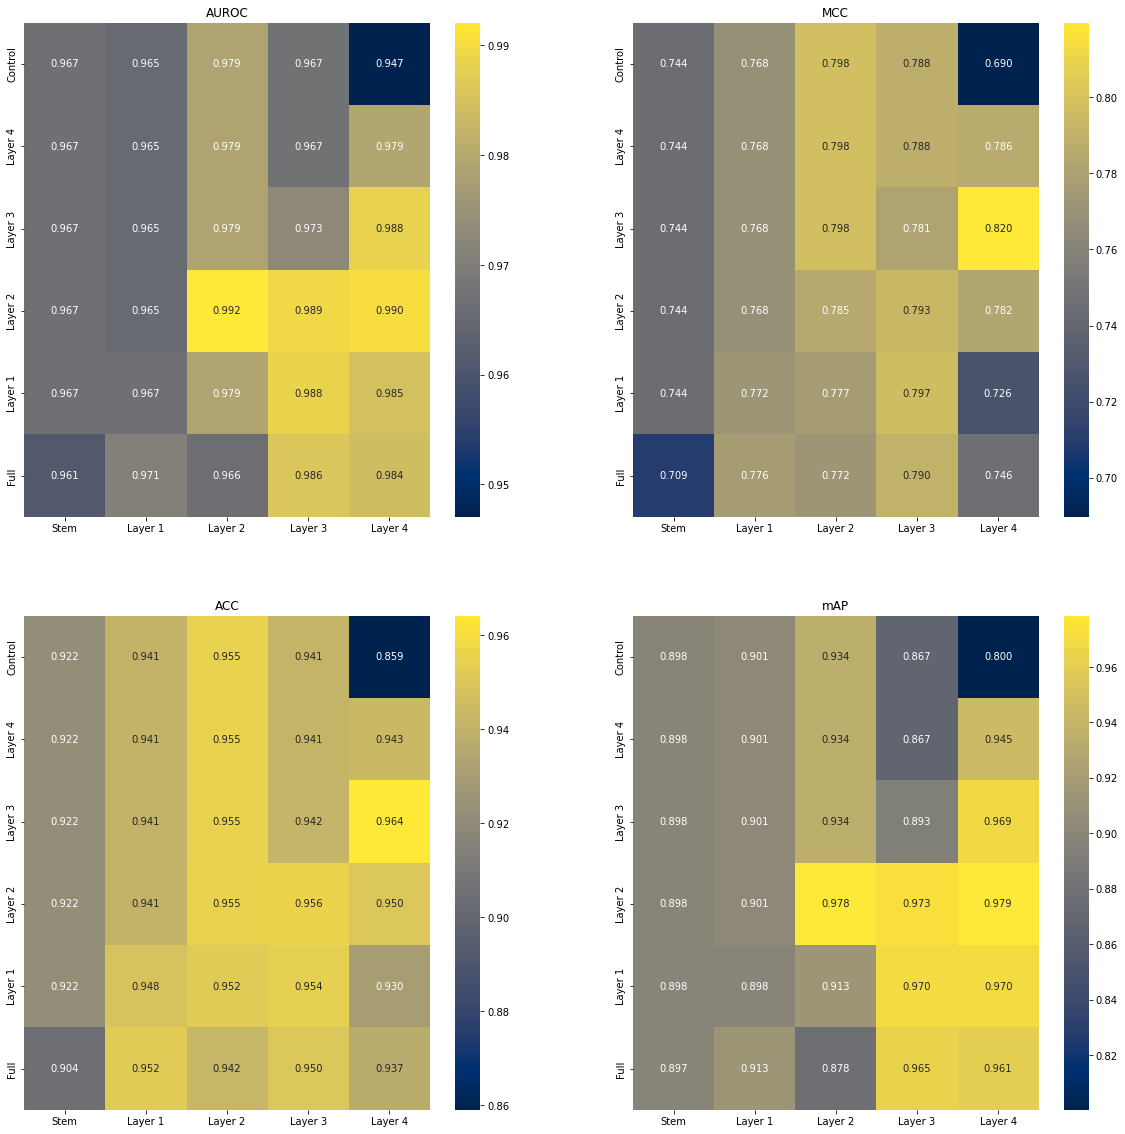

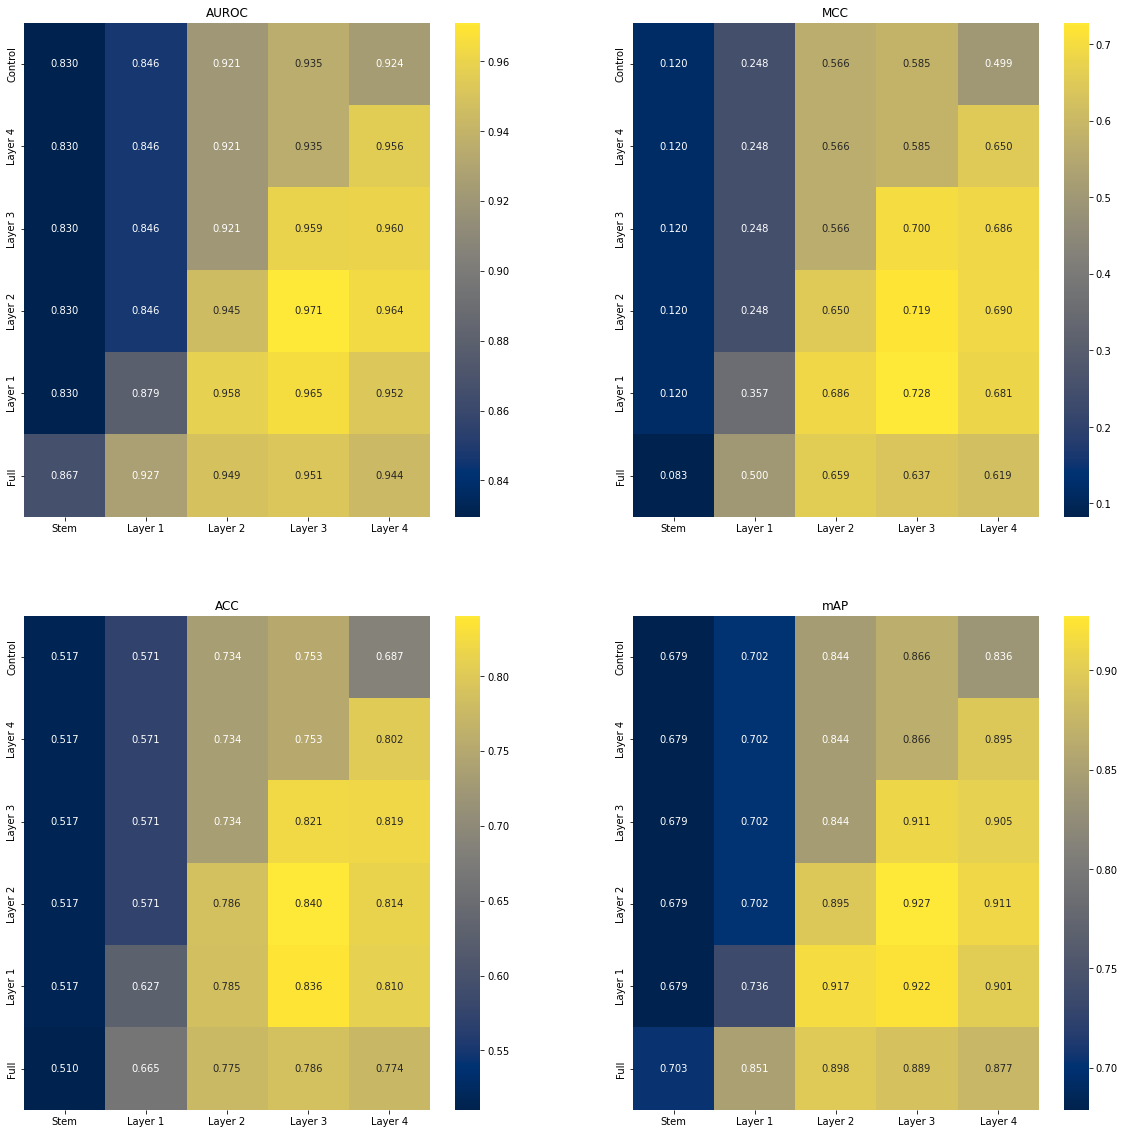

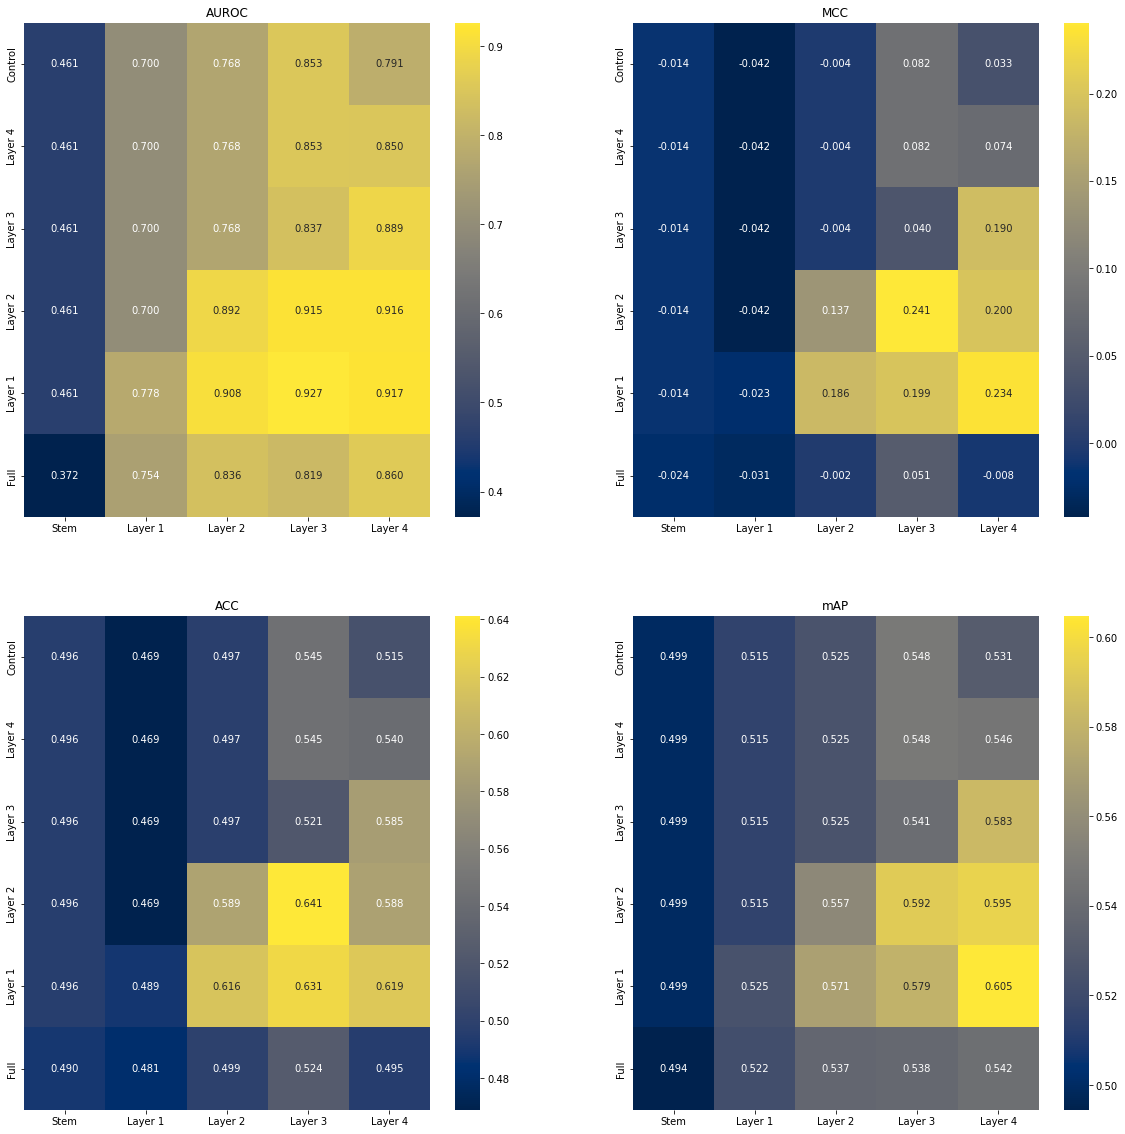

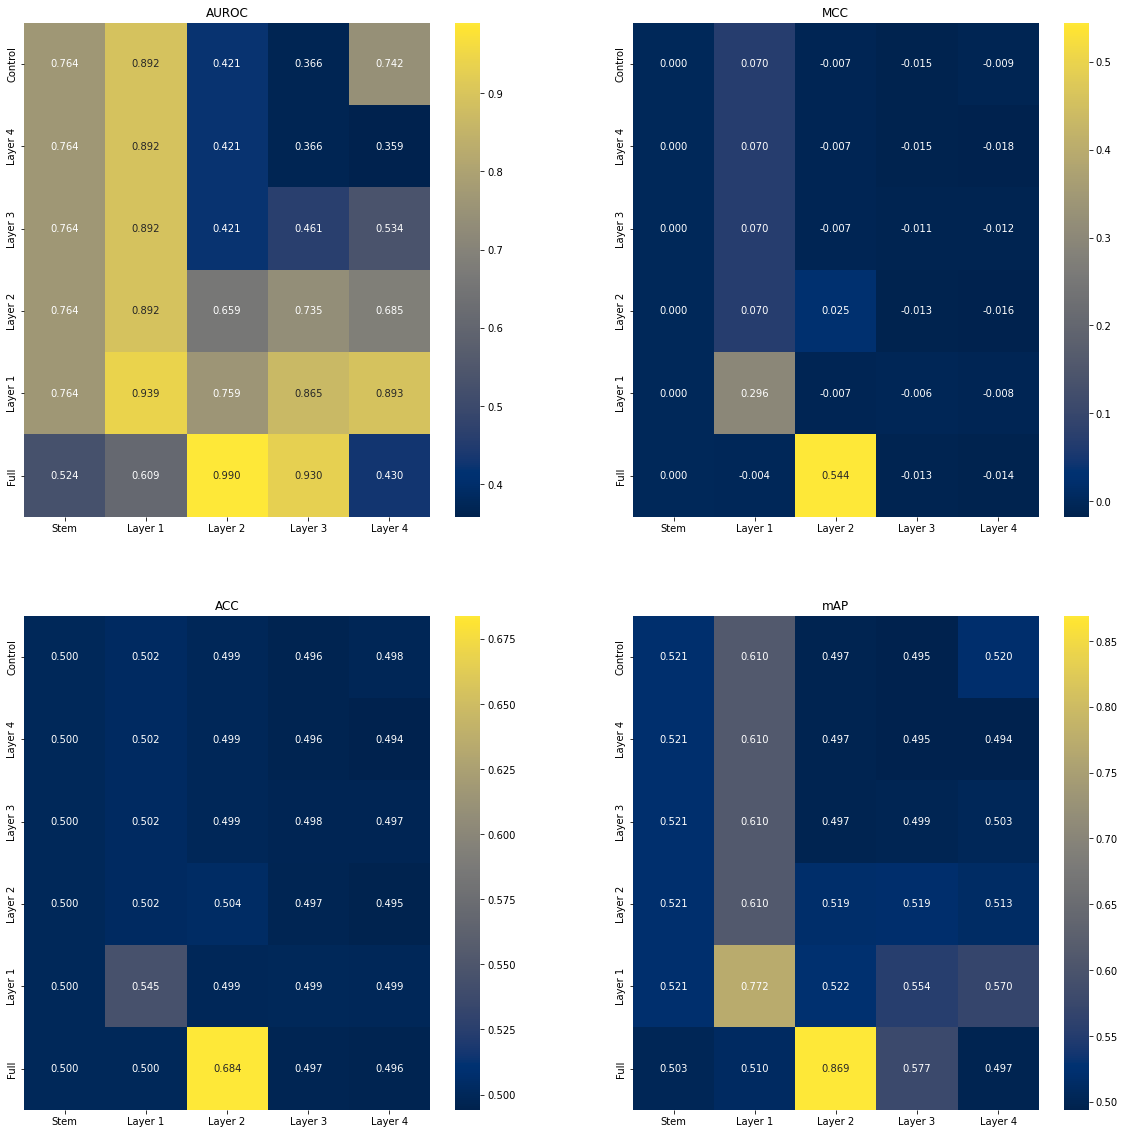

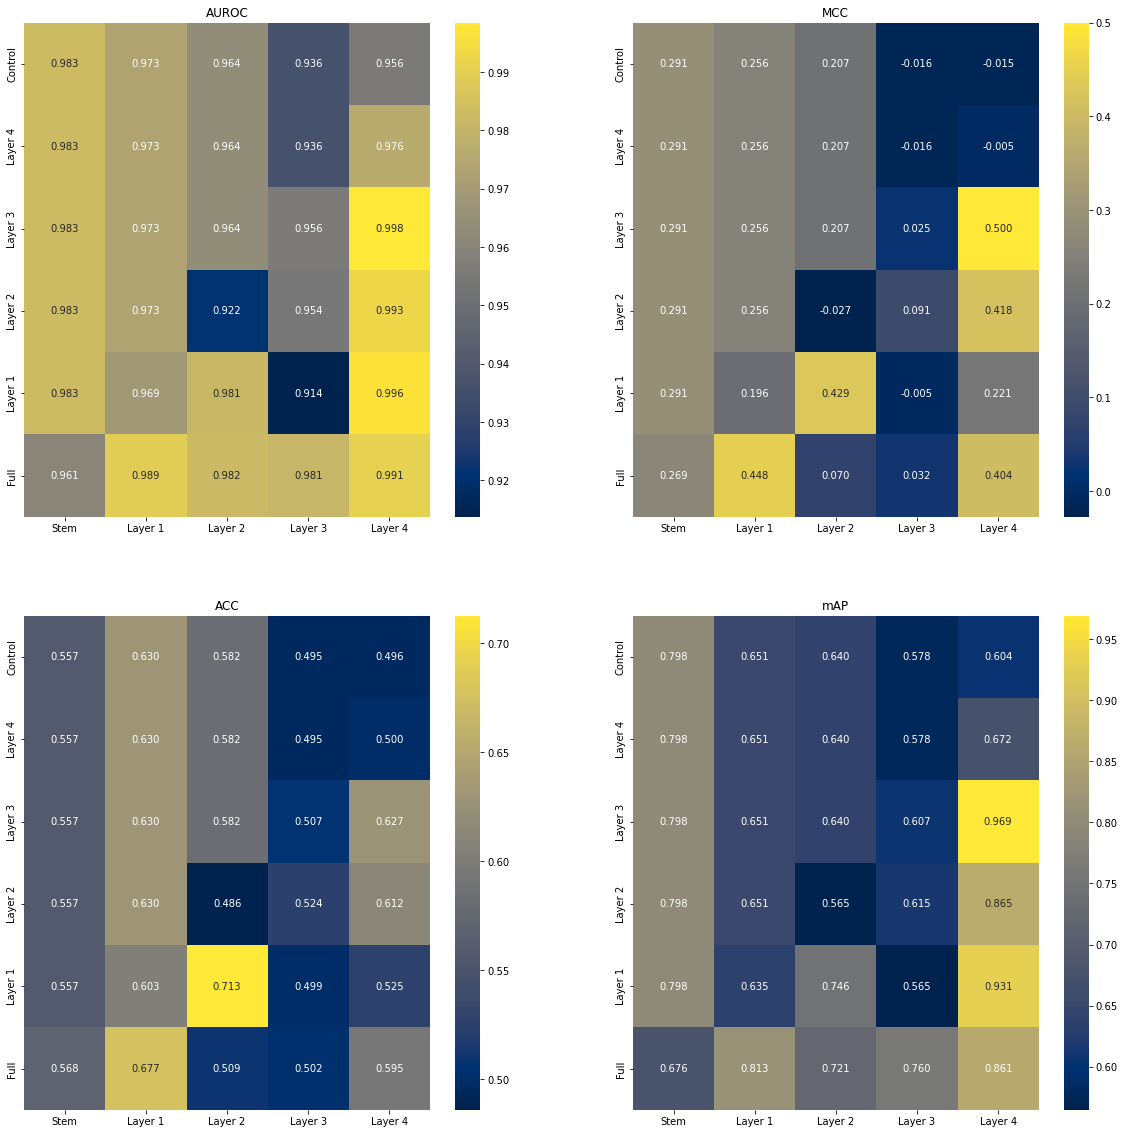

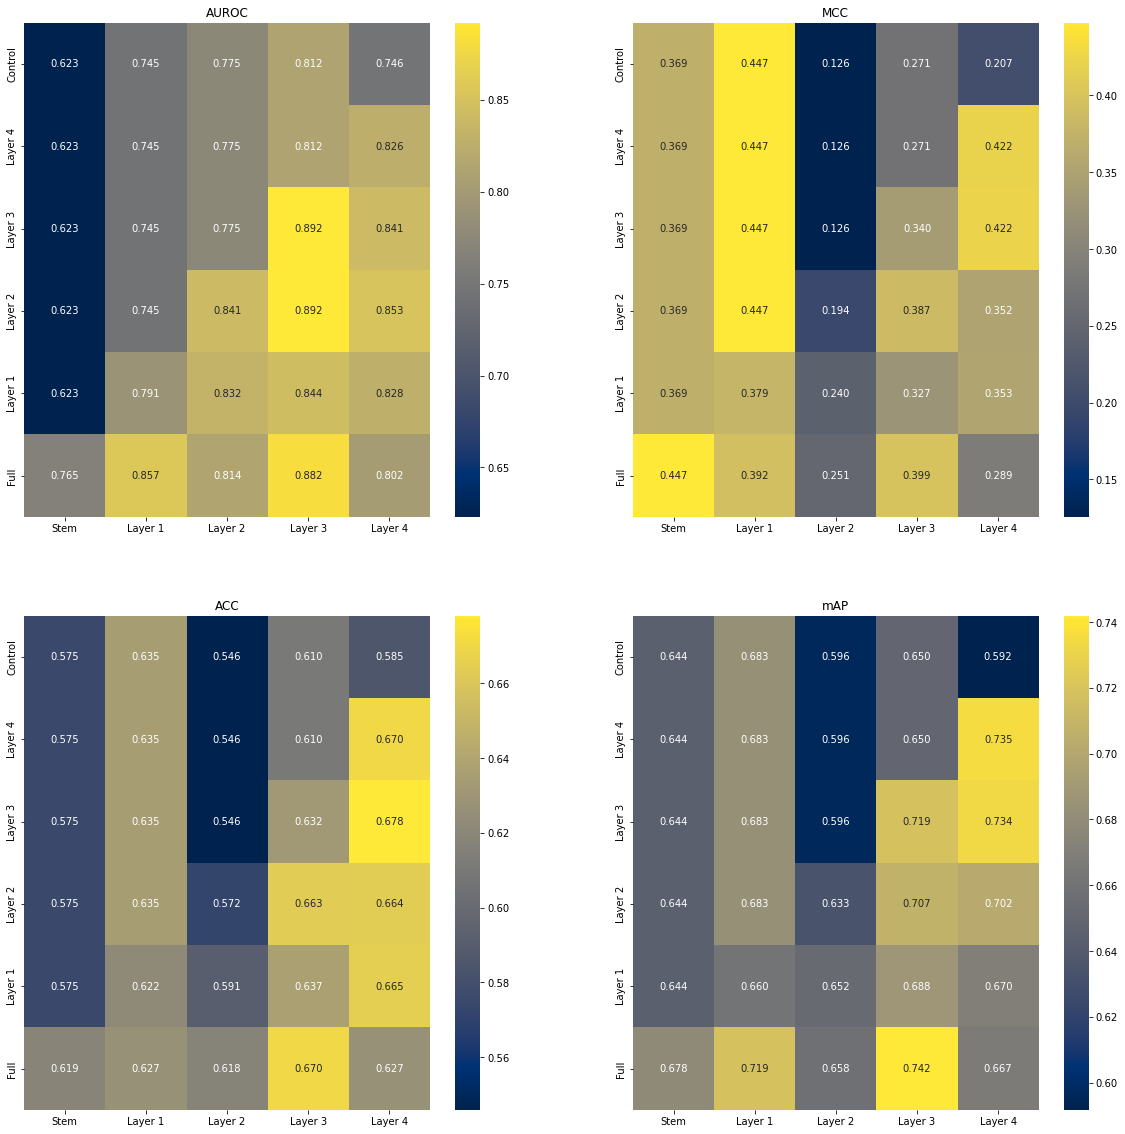

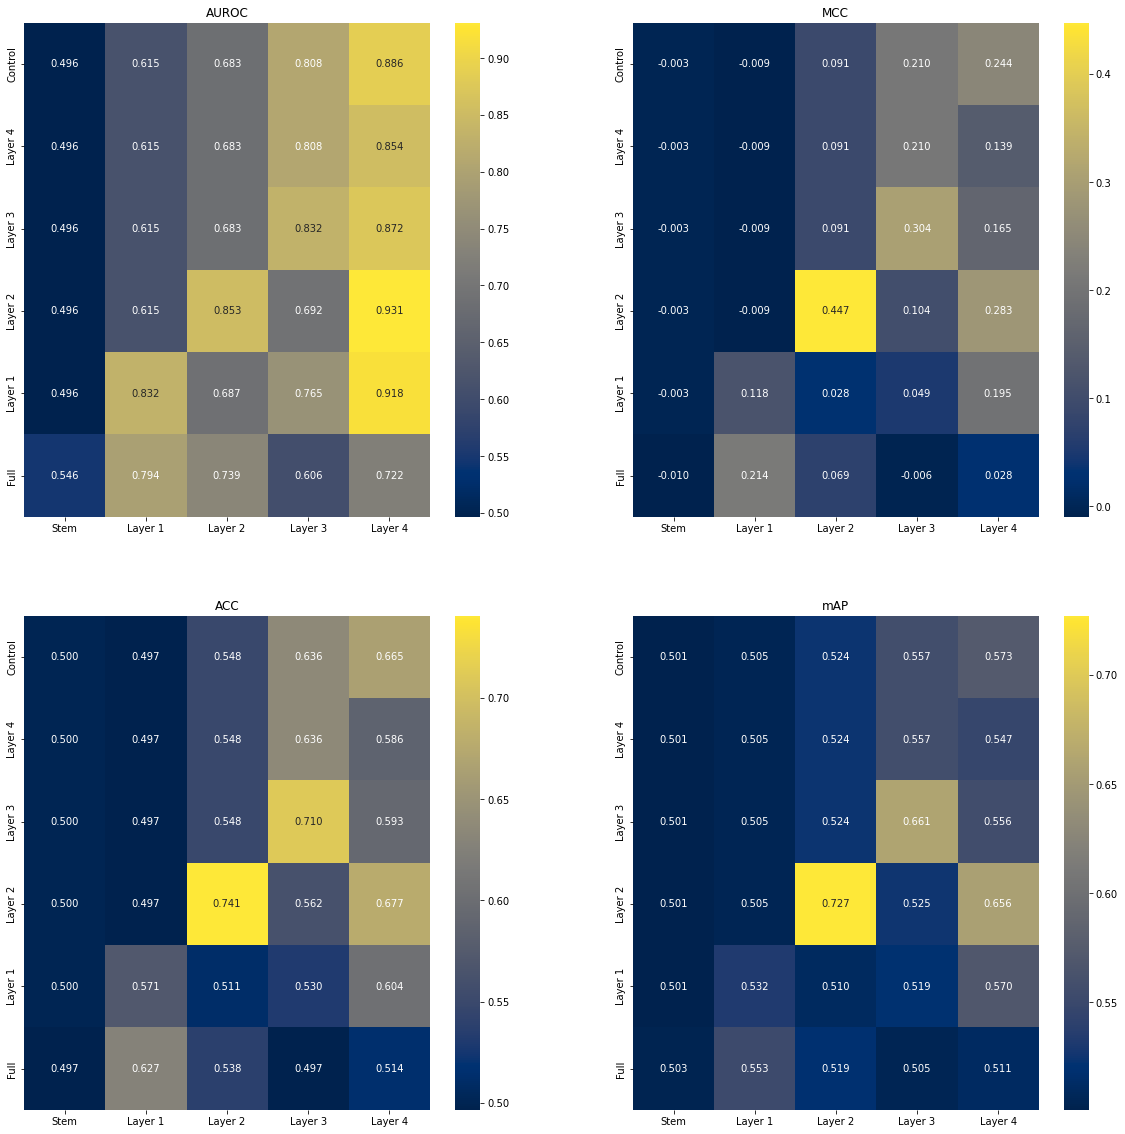

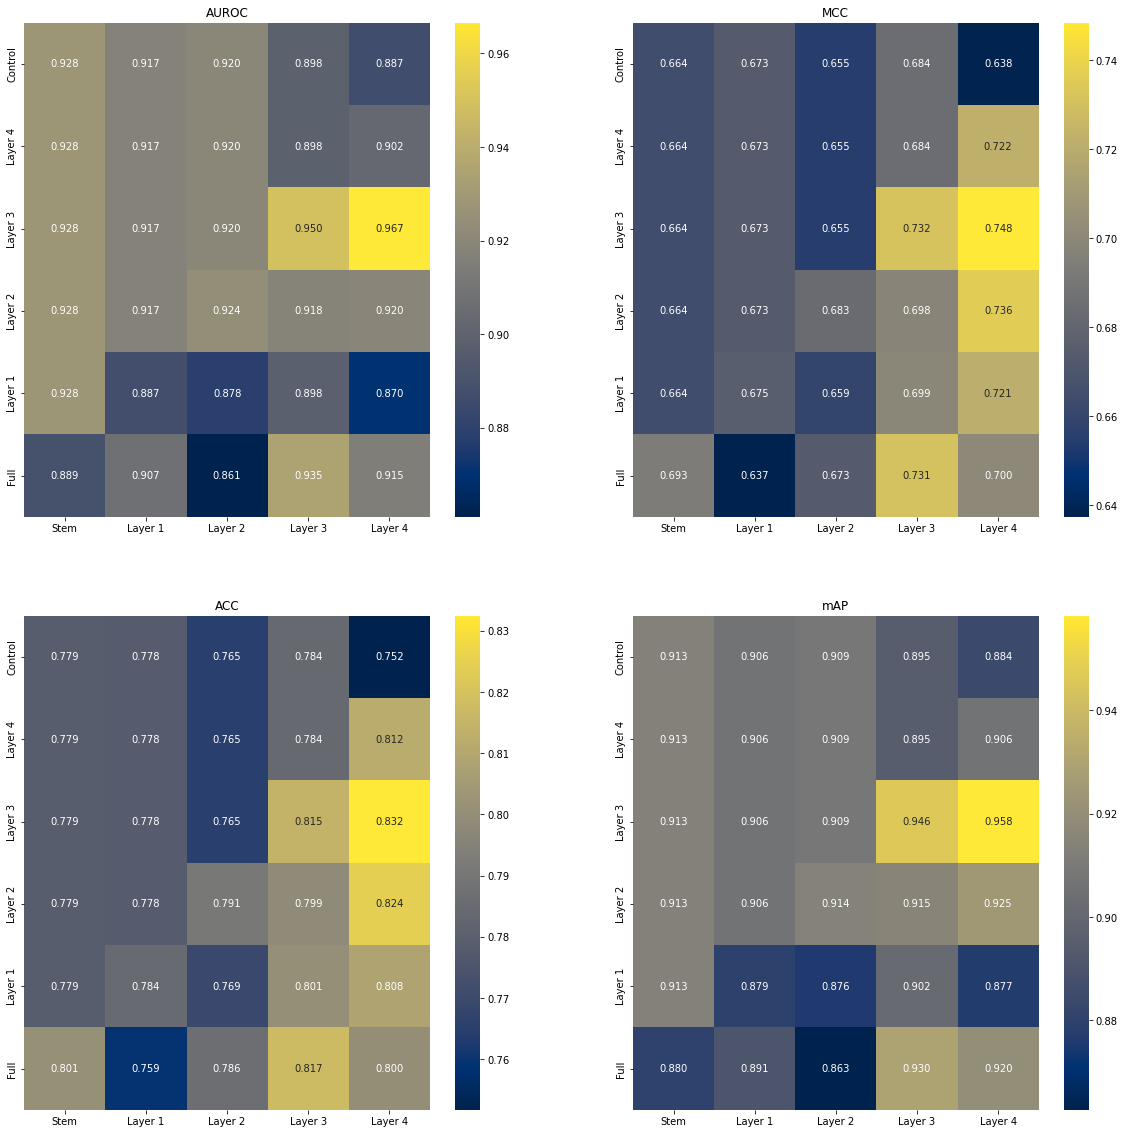

In [34]:
metrics = ["AUROC", "MCC", "ACC", "mAP"]

for ft in ft_list:
    results = res_dict[f"whole_{ft}"]
    res = np.concatenate(results[1:]).reshape(6, 5, 4)
    fig = plt.figure(figsize=(20, 20))
    for i in range(4):
        df = pd.DataFrame(res[:, :, i], index=model_name, columns=layer_name)
        ax = fig.add_subplot(2, 2, i + 1)
        sns.heatmap(df, cmap="cividis", annot=True, fmt=".3f", ax=ax)
        ax.set_title(metrics[i])
    plt.savefig(f"../../outputs/230308TGGATE_findingtype_figures_seed123_epoch5_resnet/{ft}.png", bbox_inches="tight")
    plt.show()


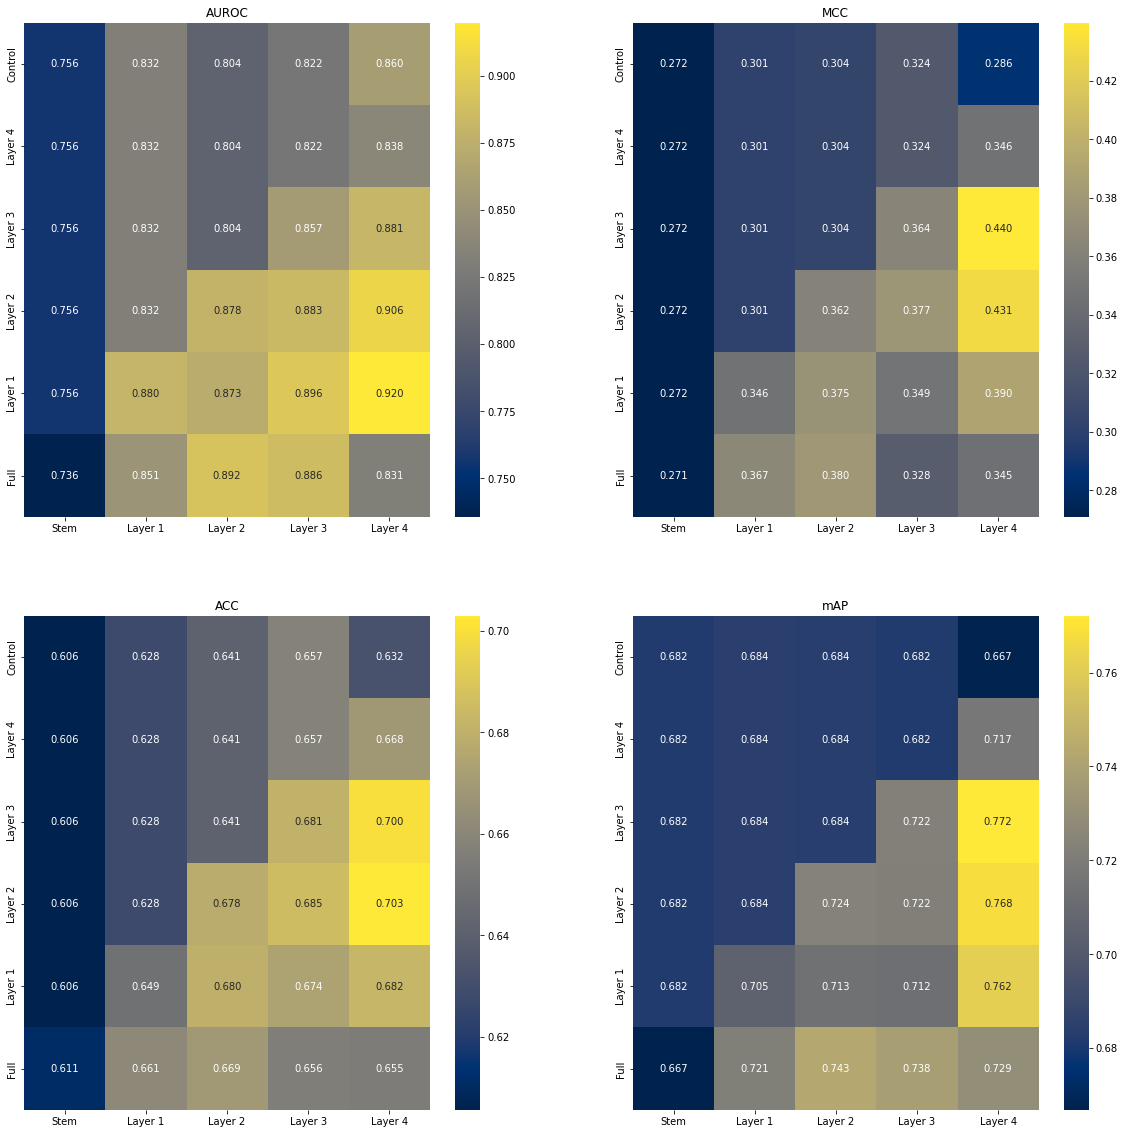

In [35]:
metrics = ["AUROC", "MCC", "ACC", "mAP"]
res_mean = 0
for ft in ft_list:
    results = res_dict[f"whole_{ft}"]
    res = np.concatenate(results[1:]).reshape(6, 5, 4)
    res_mean += res

fig = plt.figure(figsize=(20, 20))
for i in range(4):
    df = pd.DataFrame(res_mean[:, :, i]/len(ft_list), index=model_name, columns=layer_name)
    ax = fig.add_subplot(2, 2, i + 1)
    sns.heatmap(df, cmap="cividis", annot=True, fmt=".3f", ax=ax)
    ax.set_title(metrics[i])
plt.savefig(f"../../outputs/230308TGGATE_findingtype_figures_seed123_epoch5_resnet/mean.png", bbox_inches="tight")
plt.show()
